In [50]:
import os
import re
import gensim
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from collections import defaultdict
import pandas as pd


# Read all Python files in the directory
def read_python_files(directory):
    file_data = []
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                with open(file_path, 'r', encoding='utf-8') as f:
                    file_data.append(f.read())
    return file_data, file_paths

# Extract class and function names
def extract_names(files_data):
    names = []
    for data in files_data:
        classes = re.findall(r'class\s+(\w+)', data)
        functions = re.findall(r'def\s+(\w+)', data)
        names.append(classes + functions)
    return names

# Remove Python keywords and stop words
def remove_stopwords(names):
    python_keywords = {'False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield'}
    stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
    all_stopwords = python_keywords | stop_words
    filtered_names = [[name for name in name_list if name.lower() not in all_stopwords] for name_list in names]
    return filtered_names

# Perform LDA topic analysis
def lda_topic_analysis(filtered_names, num_topics=5):
    dictionary = corpora.Dictionary(filtered_names)
    corpus = [dictionary.doc2bow(name) for name in filtered_names]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda_model, corpus, dictionary

# Visualize the topic distribution
def visualize_topics(lda_model, corpus, dictionary):
    topic_words = defaultdict(list)
    for topic_id in range(lda_model.num_topics):
        topic_terms = lda_model.show_topic(topic_id, topn=10)
        for term, weight in topic_terms:
            topic_words[topic_id].append((term, weight))

    fig, axes = plt.subplots(lda_model.num_topics, 1, figsize=(15, 4*lda_model.num_topics))
    for topic_id, ax in enumerate(axes):
        words, weights = zip(*topic_words[topic_id])
        ax.bar(words, weights)
        ax.set_title(f'Topic {topic_id+1}', fontsize=16)
        ax.set_xlabel('Words', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)

    plt.tight_layout()
    plt.show()

def create_topic_table(lda_model, corpus, file_paths):
    topic_probabilities = [lda_model.get_document_topics(doc) for doc in corpus]

    table_data = []
    for file_path, topic_probs in zip(file_paths, topic_probabilities):
        row = {'File': file_path.split(r'D:\UL\sem2\CS5722 software architecture\assignment\pytorch\LDA_v1')[1]}
        for topic_id, prob in topic_probs:
            row[f'Topic {topic_id+1}'] = prob
        table_data.append(row)

    topic_table = pd.DataFrame(table_data).fillna(0)
    return topic_table

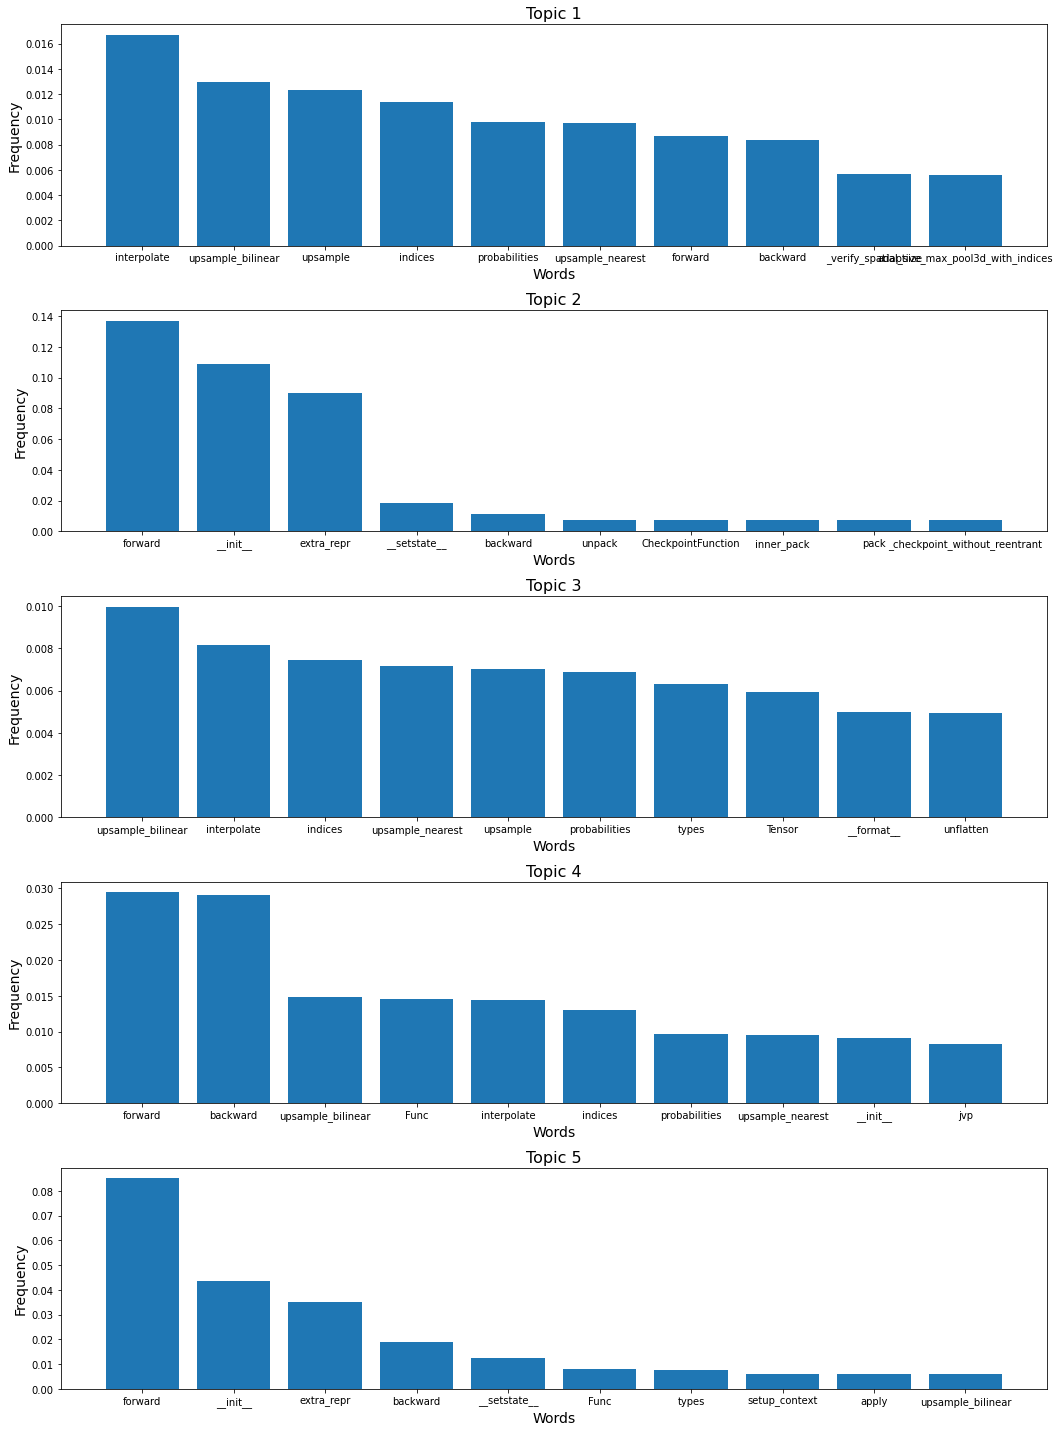

,File,Topic 5,Topic 4,Topic 2,Topic 1,Topic 3
0,\torch\_tensor.py,0.987959,0.000000,0.000000,0.000000,0.000000
1,\torch\autograd\function.py,0.098612,0.893496,0.000000,0.000000,0.000000
2,\torch\nn\functional.py,0.000000,0.993388,0.000000,0.000000,0.000000
3,\torch\nn\modules\activation.py,0.000000,0.000000,0.992636,0.000000,0.000000
4,\torch\utils\checkpoint.py,0.010576,0.010583,0.957773,0.010537,0.010531


In [54]:
# Input directory
directory_name = r'D:\UL\sem2\CS5722 software architecture\assignment\pytorch\LDA_v1\torch'

files_data, file_paths = read_python_files(directory_name)
names = extract_names(files_data)
filtered_names = remove_stopwords(names)
lda_model, corpus, dictionary = lda_topic_analysis(filtered_names)
visualize_topics(lda_model, corpus, dictionary)
topic_table = create_topic_table(lda_model, corpus, file_paths)
topic_table